In [2]:
import numpy as np
import scipy as sp
from scipy import stats
import time as time
import matplotlib
import matplotlib.pyplot as plt
import math
import cmath
import gmpy2 as gp
from gmpy2 import mpc

#####################################################################################

In [3]:
def monodromyRL(word):
    R = np.array([[1,1],[0,1]])
    L = np.array([[1,0],[1,1]])
    mon = np.array([[1,0],[0,1]])
    i = len(word)//2
    while i > 0:
        mon = mon.dot(np.dot(R,L))
        i = i-1
    return mon

def sf(word):
    return np.linalg.eig(monodromyRL(word))[0][0]

In [4]:
#This function provides a list of the admissible colors for the given level set r:
def colors(r):
    I = [i for i in range((r-3)//2+1)]
    return I

#Primitive root of unity for which we are computing all of our invariants, as a function of the level set r:
def A(r):
    B = cmath.exp(cmath.pi*1j/(r))
    return B
################################################################################################

################################################################
#Supporting functions for quantum integers and factorials
################################################################

def Q(n,A):
    z = (-A)**(n) - (-A)**(-n)
    return z.imag*1j

def Qp(n,A):
    z = (-A)**(n) + (-A)**(-n)
    return z.real
def f1(N,A):
    if N==0:
        return 1
    elif N>0:
        return np.prod([Q(i,A) for i in range(1,N+1)])
    else: 
        return 0
def f1p(N,A):
    if N==0:
        return 2
    elif N>0:
        return np.prod([Qp(i,A) for i in range(1,N+1)])
    else: 
        return 0
def f2(N,A):
    if N==0:
        return 1
    else:
        temp=1
        for i in range(N,0,-2):
            temp=temp*Q(i,A)
            continue
        return temp
def mu(n,A):
    return (-A)**(n*(n+2))
def lamb(n,A):
    return -Q(2*n+2,A)

################################################################################################

################################################################
#Functions used to construct the representations for C_R and C_L
################################################################
def R(c,n,m,A):
    x = f1(m,A)*f2(2*c+2*n+1,A)*f1p(2*c+n+1,A)
    y = f1(n,A)*f2(2*c+2*m+1,A)*f1p(2*c+m+1,A)
    return x/y

def Mminus(N,n,m,A):
    x = Q(m,A)*((-A)**(-2*N+2*m))
    y = Q(n+1,A)
    return x/y
def Mplus(N,n,m,A):
    x = ((-A)**(-2*N+2*m+2))*Q(-2*N+2*m+2,A)*Qp(-2*N+m+1,A)
    y = Q(n+1,A)
    return x/y
def Mmid1(c,N,n,m,A):
    x = (A-A**(-1))*(lamb(c+m,A))**(2)+A*(Q(m+1,A)**(2))*R(c,m+1,m,A)-A**(-1)*(Q(m,A)**2)*R(c,m,m-1,A)-Q(2,A)*lamb(c+n,A)
    y = Q(2,A)*Q(n+1,A)
    return x/y

def Mmid(c,N,n,m,A):
    x = (A-A**(-1))*(Qp(2*N-2*m-1,A))**(2)+A*(Q(m+1,A)**(2))*R(c,m+1,m,A)-A**(-1)*(Q(m,A)**2)*R(c,m,m-1,A)+Q(2,A)*Qp(2*N-2*n-1,A)
    y = Q(2,A)*Q(n+1,A)
    return x/y

def makeM(N,c,n,A):
    bigM = np.zeros(shape=(N,N),dtype=complex)
    bigM[0,0] = Mmid(c,N,n,0,A)
    bigM[0,1] = Mplus(N,n,0,A)
    bigM[N-1,N-2] = Mminus(N,n,N-1,A)
    bigM[N-1,N-1] = Mmid(c,N,n,N-1,A)
    for m in range(1,N-1):
        bigM[m,m] = Mmid(c,N,n,m,A)
        bigM[m,m-1] = Mminus(N,n,m,A)
        bigM[m,m+1] = Mplus(N,n,m,A)
    return bigM

################################################################################################

################################################################
#Build libraries for R and L representations
################################################################

def makeRepR(N,c,A):
    S = np.zeros(shape=(N,N),dtype = complex)
    S[0,0] = 1
    for n in range(1,N):
        M = makeM(N,c,n-1,A)
        S[:,n] = M.dot(S[:,n-1])
    return S

In [5]:
test = np.array(range(325))
test = test[test %4==3]

#Chen-Yang Test set for the figure eight knot complement:
CYtest = np.array([11,13,15,17,19,21,23,25,31,41,51,61,71,81,91,101,111,201,301,401,501,701,1001])
############################################################################################
def cc(r):
    return (r-3)//4

def libRmid(array):
    lib = {}
    for r in array:
        repsr = makeRepR((r-1)//2-cc(r),cc(r),A(r))
        lib[r] = repsr
    return lib

time_start = time.process_time()

Rlibmid = libRmid(test)

time_elapsed = (time.process_time() - time_start)
print('Time to build R Library: %s seconds' % time_elapsed)

#Once we have the R rep library, we can construct the corresponding library of L reps using these two functions:

def makeRepLmid(N,r,A):
    repR = Rlibmid[r]
    c=cc(r)
    S = np.linalg.inv(np.array([[repR[m,n]/R(c,n,m,A) for m in range(N)] for n in range(N)]))
    return S

def libLmid(array):
    lib = {}
    for r in array:
        repsr = makeRepLmid((r-1)//2-cc(r),r,A(r))
        lib[r] = repsr
    return lib

time_start = time.process_time()

Llibmid = libLmid(test)

time_elapsed = (time.process_time() - time_start)
print('Time to build L Library: %s seconds' % time_elapsed)

def midRep(r,string):
    #r >= 3 is odd TV parameter
    #c is color from list of colors, N = (r-1)/2 - c
    #k is choice of primitive 2r root of unity 
    #string is the string of L's and R's 
    N = (r-1)//2-cc(r)
    if 'R' in string:
        repR = Rlibmid[r]
    if 'L' in string:
        repL = Llibmid[r]
    rho = np.zeros(shape=(N,N), dtype=complex)
    first = string[0]
    if first == 'L':
        rho = repL
    else: 
        rho = repR
    for char in string[1:]:
        if char == 'L':
            rho = rho.dot(repL)
        else:
            rho = rho.dot(repR)
    return rho

def midRepVals(array, string):
    x = np.zeros(shape = (len(array),))
    y = np.zeros(shape = (len(array),))
    i=0
    for r in array:
        valr = (2*np.pi)/(r)*np.log(abs(np.trace(midRep(r,string)))**2)
        print(r,valr)
        x[i] = r
        y[i] = valr
        i=i+1
    return x,y

def midRepValsTV(array, string):
    x = np.zeros(shape = (len(array),))
    y = np.zeros(shape = (len(array),))
    i=0
    for r in array:
        valr = abs(np.trace(midRep(r,string)))**2
        print(r,valr)
        x[i] = r
        y[i] = valr
        i=i+1
    return x,y

def midRepVal(r, string):
    return (2*np.pi)/(r)*np.log(abs(np.trace(midRep(r,string)))**2)

def midRepValTV(r, string):
    return abs(np.trace(midRep(r,string)))**2

def genRLn(n):
    x = ''
    for i in range(n):
        x = x+ 'RL'
    return x

def midRepEValSum(array, string):
    x = np.zeros(shape = (len(array),))
    y = np.zeros(shape = (len(array),))
    i=0
    for r in array:
        evalr = sum(sorted(abs(np.array(np.linalg.eig(midRep(r,string))[0])),reverse=True))
        print(r,evalr)
        x[i] = r
        y[i] = evalr
        i=i+1
    return x,y

def midRepTopEVal(array, string):
    x = np.zeros(shape = (len(array),))
    y = np.zeros(shape = (len(array),))
    i=0
    for r in array:
        evalr = sorted(abs(np.array(np.linalg.eig(midRep(r,string))[0])),reverse=True)[0]
        print(r,evalr)
        x[i] = r
        y[i] = evalr
        i=i+1
    return x,y

Time to build R Library: 210.546875 seconds
Time to build L Library: 116.015625 seconds


3 0.0
7 1.453367033079135
11 1.6472185620182331
15 1.7143549747961826
19 1.7553987295439037
23 1.7870541466256498
27 1.8130994739471902
31 1.8348778859601234
35 1.8532007678872517
39 1.8687020136921795
43 1.8819021499945354
47 1.893225591411801
51 1.9030140489014955
55 1.9115405178483902
59 1.919022566019372
63 1.9256338610959098
67 1.9315136212043136
71 1.936774112758759
75 1.9415064931341037
79 1.9457853241857215
83 1.9496720493934576
87 1.9532176754886659
91 1.956464847917842
95 1.959449465412334
99 1.9622019436873699
103 1.9647482110527223
107 1.9671104982265093
111 1.9693079692668507
115 1.9713572289232149
119 1.9732727336613027
123 1.9750671258440657
127 1.976751509854927
131 1.9783356744191736
135 1.9798282878965816
139 1.9812370467451363
143 1.9825688071422904
147 1.9838297079228409
151 1.9850252385258427
155 1.9861603695879402
159 1.9872395078409453
163 1.9882667730144503
167 1.9892457736346323
171 1.9901799192380545
175 1.9910707258861493
179 1.991923874528745
183 1.992742371

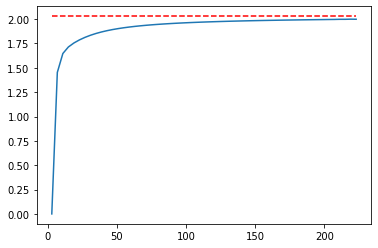

In [6]:
x,y = midRepVals(test[test <225],'RL')
vol = np.array([2.029883128 for i in range(len(x))])
plt.plot(x,y)
plt.plot(x,vol,'r--')
plt.show()

3 1.0
7 1.63557312992222
11 2.881688664511578
15 5.367138364575826
19 10.140801125842444
23 19.24089338663858
27 36.57375737952673
31 69.59216168968834
35 132.50629358091285
39 252.41080061604907
43 480.9712351598207
47 916.7138472869995
51 1747.5407767881707
55 3331.825753166895
59 6353.105265168679
63 12115.162495935052
67 23104.934118205183
71 44066.34402049308
75 84048.85125754696
79 160315.52466159558
83 305798.70767480927
87 583323.831173216
91 1112745.7488174958
95 2122720.3091945453
99 4049476.852775188
103 7725263.300266611
107 14737877.994332083
111 28116621.069907457
115 53641031.59023176
119 102337863.9669796
123 195245167.5806436
127 372501920.10016584
131 710690662.6082926
135 1355926808.063313
139 2586992190.009736
143 4935792933.450326
147 9417193037.678566
151 17967533590.75297
155 34281347312.334793
159 65407739373.62999
163 124796623562.93004
167 238110392816.50085
171 454314469532.52136
175 866809070624.9283
179 1653885433727.622
183 3155775634900.877
187 6020621706

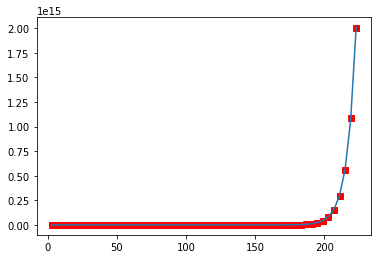

3 1.0
7 1.63557312992222
11 2.881688664511578
15 5.367138364575826
19 10.140801125842444
23 19.24089338663858
27 36.57375737952673
31 69.59216168968834
35 132.50629358091285
39 252.41080061604907
43 480.9712351598207
47 916.7138472869995
51 1747.5407767881707
55 3331.825753166895
59 6353.105265168679
63 12115.162495935052
67 23104.934118205183
71 44066.34402049308
75 84048.85125754696
79 160315.52466159558
83 305798.70767480927
87 583323.831173216
91 1112745.7488174958
95 2122720.3091945453
99 4049476.852775188
103 7725263.300266611
107 14737877.994332083
111 28116621.069907457
115 53641031.59023176
119 102337863.9669796
123 195245167.5806436
127 372501920.10016584
131 710690662.6082926
135 1355926808.063313
139 2586992190.009736
143 4935792933.450326
147 9417193037.678566
151 17967533590.75297
155 34281347312.334793
159 65407739373.62999
163 124796623562.93004
167 238110392816.50085
171 454314469532.52136
175 866809070624.9283
179 1653885433727.622
183 3155775634900.877
187 6020621706

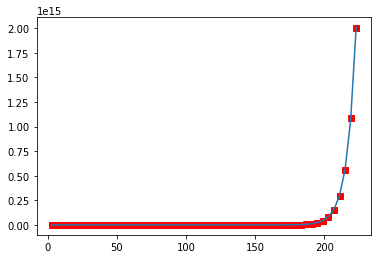

True
True


In [7]:
x,y = midRepTopEVal(test[test <225],'RL')
plt.plot(x,y,'rs')

fit = sp.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y,  p0=(1, 0.15))
a = fit[0][0]
b = fit[0][1]
print('------------------------------')
print(a,b)
fity = [a*np.exp(b*t) for t in x]
plt.plot(x,fity)

plt.show()
plt.close()

xs,ys = midRepTopEVal(test[test <225],'RL')
plt.plot(x,y,'rs')

fits = sp.optimize.curve_fit(lambda t,aa,bb: aa*np.exp(bb*t),  xs,  ys,  p0=(1, 0.15))
aa = fits[0][0]
bb = fits[0][1]
print('------------------------------')
print(aa,bb)
fitys = [aa*np.exp(bb*t) for t in xs]
plt.plot(xs,fitys)


plt.show()

print(a==aa)
print(b==bb)

For r=3, slope = 0.0 and r_value = 0.0
For r=7, slope = 0.8809559969221087 and r_value = 0.999978895050284
For r=11, slope = 1.2075115686433717 and r_value = 0.9999936162839365
For r=15, slope = 1.4066825302936368 and r_value = 0.9999977473688434
For r=19, slope = 1.5314545865346842 and r_value = 0.9999990007925367
For r=23, slope = 1.6150937487371526 and r_value = 0.9999994715611432
For r=27, slope = 1.6747845798577576 and r_value = 0.9999996822664419
For r=31, slope = 1.7194803546429003 and r_value = 0.9999997902047738
For r=35, slope = 1.7541916599872789 and r_value = 0.9999998516081209
For r=39, slope = 1.7819250725471523 and r_value = 0.9999998895245915
For r=43, slope = 1.8045913140745775 and r_value = 0.9999999144989393
For r=47, slope = 1.8234622676264316 and r_value = 0.999999931811322
For r=51, slope = nan and r_value = nan
For r=55, slope = nan and r_value = nan
For r=59, slope = nan and r_value = nan
For r=63, slope = nan and r_value = nan
For r=67, slope = nan and r_value 

C:\Users\mreclyde\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: overflow encountered in double_scalars


For r=71, slope = nan and r_value = nan
For r=75, slope = nan and r_value = nan
For r=79, slope = nan and r_value = nan
For r=83, slope = nan and r_value = nan
For r=87, slope = nan and r_value = nan
For r=91, slope = nan and r_value = nan
For r=95, slope = nan and r_value = nan
For r=99, slope = nan and r_value = nan
For r=103, slope = nan and r_value = nan
For r=107, slope = nan and r_value = nan
For r=111, slope = nan and r_value = nan
For r=115, slope = nan and r_value = nan
For r=119, slope = nan and r_value = nan
For r=123, slope = nan and r_value = nan
For r=127, slope = nan and r_value = nan
For r=131, slope = nan and r_value = nan
For r=135, slope = nan and r_value = nan
For r=139, slope = nan and r_value = nan
For r=143, slope = nan and r_value = nan
For r=147, slope = nan and r_value = nan
For r=151, slope = nan and r_value = nan
For r=155, slope = nan and r_value = nan
For r=159, slope = nan and r_value = nan
For r=163, slope = nan and r_value = nan
For r=167, slope = nan a

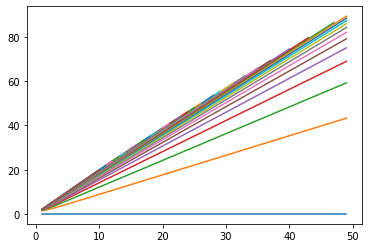

In [88]:
mfds = [genRLn(n) for n in range(1,50)]
#print(mfds)
x = range(1,len(mfds)+1)
for r in test[test <225]:
    y = [midRepVal(r,word) for word in mfds]
    plt.plot(x,y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    print("For r=%s, slope = %s and r_value = %s" %(r,slope,r_value))
plt.show()

In [64]:
def K(n):
    return n

def Zn(word):
    n = len(word)//2
    return midRepVal(K(n), word)**(1/float(K(n)))

def Z(word,r):
    n = len(word)//2
    val = midRepVal(r, word)
    return val**(1/float(n))

def mfds3(arr):
    m = []
    for word in arr:
        if len(word)//2 %4==3:
            m.append(word)
    return m

In [65]:
mfdslite = mfds3(mfds)
print(mfdslite)
print(len(mfdslite[-1]))

['RLRLRL', 'RLRLRLRLRLRLRL', 'RLRLRLRLRLRLRLRLRLRLRL', 'RLRLRLRLRLRLRLRLRLRLRLRLRLRLRL', 'RLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRL', 'RLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRL', 'RLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRL', 'RLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRL', 'RLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRL', 'RLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRL', 'RLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRL', 'RLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRLRL']
94


In [66]:
for word in mfdslite:
    n = len(word)//2
    print((n,sf(word).round(2),Zn(word)))

(3, 17.94, 0.0)
(7, 843.0, 1.2973062543519962)
(11, 39603.0, 1.2652263119759575)
(15, 1860498.0, 1.2254803664542675)
(19, 87403803.0, 1.1941407313479917)
(23, -2304240806.3, 1.1702099104554886)
(27, 2372484756.06, 1.1516281795945413)
(31, -2001325594.39, 1.1368541476894716)
(35, 1244132184.28, 1.1248431837645667)
(39, -428557807.51, 1.114887978389832)
(43, -1939321143.34, 1.1064995631332668)
(47, -2792381523.27, 1.099331353791282)


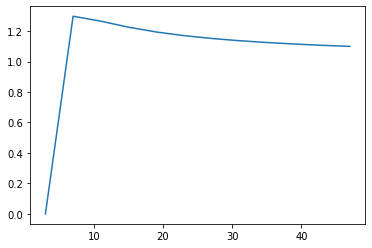

In [90]:
xmfdslite = [len(word)//2 for word in mfdslite]

y = [Zn(word) for word in mfdslite]

plt.plot(xmfdslite,y)
plt.show()

(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(3, 0.0)
(7, 1.453367033079135)
(7, 1.4146590215408372)
(7, 1.3995035100631172)
(7, 1.3743409175289185)
(7, 1.34668067238992)
(7, 1.3205975722273748)
(7, 1.2973062543519962)
(7, 1.2768808711209232)
(7, 1.259030894746623)
(7, 1.2433905717660714)
(7, 1.2296161846209765)
(7, 1.2174124322616053)
(7, 1.2065340416559)
(7, 1.1967797199155152)
(7, 1.1879846209435971)
(7, 1.180013393378903)
(7, 1.1727543543421324)
(7, 1.1661147955339661)
(7, 1.1600172634786)
(7, 1.154396628194723)
(7, 1.1491977730868301)
(7, 1.1443737687887565)
(7, 1.1398844227279683)
(7, 1.1356951206372

C:\Users\mreclyde\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: overflow encountered in double_scalars


ValueError: x and y must have same first dimension, but have shapes (49,) and (637,)

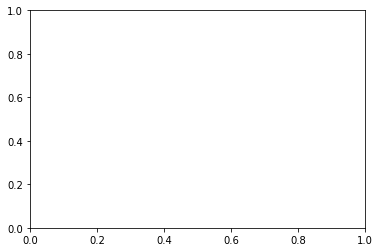

In [89]:
xmfds = [len(word)//2 for word in mfds]
y = []
for r in test[test<53]:
    for word in mfds:
        print((r,Z(word,r)))
        print(np.log(Z(word,r))/np.log(sf('RL')))
        y.append(Z(word,r))
    plt.plot(xmfds,y)
plt.show()

In [79]:
print(np.log(1.0995348786870665)/np.log(sf('RL'))
print(c)

0.09859197954492481
